In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

In [6]:
def q_s(T,P):
    # saturation specific humidity (gr water vapor per gram moist air):
    # inputs:
    # T: temperature, in Kelvin
    # P: pressure, in mb
    TT = T-273.15 # Kelvin to Celsius
    # Saturation water vapor pressure (mb) from Emanuel 4.4.14 p 116-117: 
    ew = 6.112*np.exp((17.67 * TT) / (TT + 243.5))
    # saturation mixing ratio (gr water vapor per gram dry air):
    rw = (R_gas/ R_v) * ew / (P - ew)
    # saturation specific humidity (gr water vapor per gram moist air):
    qw = rw / (1 + rw)
    return qw

In [7]:
R_gas = 287 #J/kgK
R_v = 461 #gas constant for moist air J/(kg*K)


### Model Constants ###

L = 2.25e6 # [J/kg]
R = 462 # [J/Kkg] gas constant for water vapor
Ra = 287 # [J/Kkg] gas constant for air
g = 9.8 # [m/s2] surface gravity 
sigma = 5.67e-8 # [W/m2 1/K^4] Stephan-Boltzman constant
V = 7.1 # [m/s] 10-m wind speed, Bretherton et al. (1997)
C_T = 0.001*(1+0.07*V) # transport parameter, Bretherton et al. (1997)
Po = 1000 # [hPa]
cp = 1005.7 # [J/kg/K] specific heat of air
H = 8500 # scale height (m)
alpha_c = 0.8 # maximum albedo of cloud
alpha_w = 0.06 # albedo of open water
rho_a = 1.225 #kg/m3
D = 1.66 # diffusivity factor
kappa = 0.090361*1000 # m2/g
A = 0.05 # climate sensitivity to CO2
B = 0.1 # climate sensitivity to H2O
Cs = 4.19e3 * 1000 # heat capacity of surface
### Values Taken from Schneider et al. (2019) ### 

S = 471 # [W/m2], June insolation in subtropics

### Tuned Parameters to give best match with Schneider et al. (2019) ### 

Tao = 290 # [K], temperature of free troposphere
RHi = 0.56 # relative humidy of inversion
eps_o = 0.4 # baseline emissivity of mixed layer
eps_io = 0.45 # minimum inversion emissivity

delta_h = 300 # [m] cloud layer thickness
z_cloud = 1000 # [m] cloud top 
we = 0.01
qi = q_s(Tao,700)*RHi
qc_crit = 0.5

OHU = 10

Instability parameter (Schneider et al. 2019):

\begin{equation}
S = \frac{\mathrm{LHF}}{\mathrm{LWC}}\frac{h_c}{h}
\end{equation}

In [8]:
def strato_boxmodel(x, CO2):
    SST = x[0]*SST_norm # sea surface temp (K)
    Tc = x[1]*SST_norm # temperature of cloud layer (K)
    qt = x[2]*moist_norm # kg/kg water vapor mixing ratio in cloud layer
    coupling_flag = x[3] # for diagnostics 
    
    
    Ta = Tao + 3*np.log2(CO2/280)
    qi = q_s(Ta,700)*RHi
    qio = q_s(Tao,700)*RHi
    eps_i = eps_io + A*np.log2(CO2/280) + B*np.log2(qi/qio) # Equation (17)
    qs_surf = q_s(SST, 1000)
    
    qc = np.minimum(qt, q_s(Tc, 800)) # is qt above saturation?
    ql = qt - qc # if so, the rest is liquid water
    
    LHF = C_T*V*L*(qs_surf-qt) # latent heat flux
    LWP = ql*rho_a/2 * delta_h # liquid water path
    alpha = alpha_c - (alpha_c - alpha_w)*np.exp(-D*kappa*LWP)
    eps_c = 1 - (1 - eps_o)*np.exp(-D*kappa*LWP)
    LWC = -(eps_c*sigma*SST**4 + eps_i*eps_c*sigma*Ta**4 - 2*eps_c*sigma*Tc**4)
    crit = LHF/LWC * (delta_h/z_cloud) # coupling criteria

    
    if crit <= 0.6: # convecting
        Q = C_T*V*(qs_surf-qt) # moisture flux
        LHF_c = LHF*1
        flag = 1
    else: # not convecting
        Q = 0 # no moisture flux
        LHF_c = 0 # no latent heat release
        flag = -1
        

    dSSTdt = S*(1-alpha) + eps_i*(1-eps_c)*sigma*Ta**4 - sigma*SST**4 - LHF + eps_c*sigma*Tc**4- OHU
    dTcdt = eps_c*sigma*SST**4 + eps_i*eps_c*sigma*Ta**4 + we*cp*rho_a*(Ta-Tc) - 2*eps_c*sigma*Tc**4 + LHF_c
    dqcdt = Q - we*(qt-qi)
    flagging = coupling_flag - flag
    
    return(dSSTdt/SST_norm, dTcdt/SST_norm, dqcdt/moist_norm, flagging) # non-dimensionalized for convergence

In [9]:
SST_norm = 300
moist_norm = 1e-3
def get_CO2_hist(CO2_list, N=200):
    # N = number of guesses per Co2 value, default = 200, finds multiple equilibria
    # CO2_list = list of CO2 values over which to get equilibria
    solution = []
    for j in range(len(CO2_list)):
        CO2 = CO2_list[j]
        for i in range(N):
            q_guess = np.random.uniform(low = 1e-3, high = 3e-2)/moist_norm
            SST_guess = np.random.uniform(low = 290, high = 305)/SST_norm
            Tc_guess = np.random.uniform(low = 280, high = 295)/SST_norm
            guess = [SST_guess, Tc_guess, q_guess, 0.5]
            sol = fsolve(strato_boxmodel, guess, args = (CO2))
            if np.all(np.isclose(strato_boxmodel(sol, CO2),0,atol = 1e-5)):# check convergence
                sol=list(sol*[SST_norm, SST_norm, moist_norm, 1])
                sol.insert(0,CO2)
                solution.append(sol)
    unique_solutions = []
    for j in range(len(solution)):
        Ts = np.array(solution)[j,1]
        if np.isclose(np.array(solution)[j-1,1],Ts):#: # skip identical solutions
            continue
        unique_solutions.append(solution[j])
    unique_coupled = np.array(unique_solutions)[np.array(unique_solutions)[:,-1] == 1]
    unique_decoupled = np.array(unique_solutions)[np.array(unique_solutions)[:,-1] == -1]
    return(unique_coupled, unique_decoupled)

In [ ]:
coupled, decoupled = get_CO2_hist(np.linspace(280,3000,50), N=50)

/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


In [ ]:
plt.figure(dpi=120)
plt.plot(np.array(coupled)[:,0], np.array(coupled)[:,1],'r.', label = 'SST')
plt.plot(np.array(decoupled)[:,0], np.array(decoupled)[:,1],'b.', label = 'SST')
plt.ylim(285,310)
plt.ylabel('SST (K)')
plt.xlabel('CO2 (ppm)')
plt.grid()

In [179]:
def diag(x):
    CO2 = x[0]
    SST = x[1] # sea surface temp (K)
    Tc = x[2] # temperature of cloud layer (K)
    qt = x[3] # kg/kg water vapor mixing ratio in cloud layer
    coupling_flag = x[4]
    
    
    Ta = Tao + 3*np.log2(CO2/280)
    qi = q_s(Ta,700)*RHi
    qio = q_s(Tao,700)*RHi
    eps_i = eps_io + A*np.log2(CO2/280) + B*np.log2(qi/qio) # Equation (17)
    qs_surf = q_s(SST, 1000)
    
    qc = np.minimum(qt, q_s(Tc, 800)) # is qt above saturation?
    ql = qt - qc # if so, the rest is liquid water
    
    LHF = C_T*V*L*(qs_surf-qt) # latent heat flux
    LWP = ql*rho_a/2 * delta_h # liquid water path
    alpha = alpha_c - (alpha_c - alpha_w)*np.exp(-D*kappa*LWP)
    eps_c = 1 - (1 - eps_o)*np.exp(-D*kappa*LWP)
    LWC = -(eps_c*sigma*SST**4 + eps_i*eps_c*sigma*Ta**4 - 2*eps_c*sigma*Tc**4)
    crit = LHF/LWC * (delta_h/z_cloud)
    #print(LHF, LWC)
    if crit <= 0.6: # convecting
        Q = C_T*V*(qs_surf-qt) # moisture flux
        LHF_c = LHF*1
        flag = 1
    else: # not convecting
        Q = 0 # no moisture flux
        LHF_c = 0
        flag = -1
        
    LWP = ql*rho_a/2 *delta_h
    alpha = alpha_c - (alpha_c - alpha_w)*np.exp(-D*kappa*LWP)
    eps_c = 1 - (1 - eps_o)*np.exp(-D*kappa*LWP)
    return(crit, LWP, alpha, eps_c, eps_i,ql, LHF, LWC) # returns diagnostic parameters

In [174]:
diags_decoupled = np.zeros([len(decoupled), 8])
for i in range(len(decoupled)):
    diags_decoupled[i] = diag(decoupled[i])
    
    
diags_coupled = np.zeros([len(coupled), 8])
for i in range(len(coupled)):
    diags_coupled[i] = diag(coupled[i])

Text(0.5, 0, 'CO2 (ppm)')

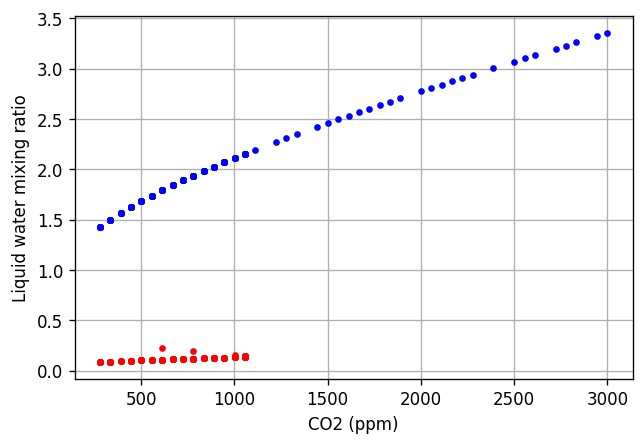

In [175]:
plt.figure(dpi=120)
plt.plot(np.array(decoupled)[:,0], diags_decoupled[:,0],'b.')
plt.plot(np.array(coupled)[:,0], diags_coupled[:,0],'r.')
plt.grid()
plt.ylabel('Liquid water mixing ratio (m2/kg)')
plt.xlabel('CO2 (ppm)')
#plt.ylim(0,0.5)